In [49]:
!pip install kaggle
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install librosa
!pip install Pillow

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import os
from PIL import Image
from keras.preprocessing.image import img_to_array
from PIL import Image

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# To load the CSV file into a Pandas DataFrame(df)
csv_file = '/content/drive/MyDrive/BirdDataset/selected_data.csv'
df = pd.read_csv(csv_file)

In [4]:
df.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,author,primary_label,longitude,length,time,recordist,license,resampled_sampling_rate,resampled_filename,resampled_channels
0,4.5,no,aldfly,1 (mono),2014-05-25,Not specified,72,XC179600.mp3,Not specified,Alder Flycatcher,...,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-93.329,Not specified,06:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 4.0,32000,XC179600.wav,1 (mono)
1,4.5,no,aldfly,2 (stereo),2019-06-07,Not specified,98,XC479504.mp3,Not specified,Alder Flycatcher,...,Meena Haribal,Empidonax alnorum_Alder Flycatcher,-76.3351,Not specified,10:00,Meena Haribal,Creative Commons Attribution-NonCommercial-Sha...,32000,XC479504.wav,1 (mono)
2,4.5,no,aldfly,1 (mono),2014-06-14,level,41,XC188434.mp3,level,Alder Flycatcher,...,Richard E. Webster,Empidonax alnorum_Alder Flycatcher,-120.0314,0-3(s),04:52,Richard E. Webster,Creative Commons Attribution-NonCommercial-Sha...,32000,XC188434.wav,1 (mono)
3,4.0,NaN,aldfly,1 (mono),2013-07-23,Not specified,22,XC157462.mp3,Not specified,Alder Flycatcher,...,Ian Cruickshank,Empidonax alnorum_Alder Flycatcher,-103.3548,Not specified,08:00,Ian Cruickshank,Creative Commons Attribution-NonCommercial-Sha...,32000,XC157462.wav,1 (mono)
4,3.5,no,aldfly,2 (stereo),2016-06-19,Not specified,64,XC331564.mp3,Not specified,Alder Flycatcher,...,Martin St-Michel,Empidonax alnorum_Alder Flycatcher,-74.2627,Not specified,06:19,Martin St-Michel,Creative Commons Attribution-NonCommercial-Sha...,32000,XC331564.wav,1 (mono)


In [5]:
# This will get us the unique bird species in the 'ebird_code' column from csv_file
unique_bird_species = df['ebird_code'].unique()
unique_bird_species

array(['aldfly', 'ameavo', 'amebit', 'amecro', 'amegfi', 'amekes',
       'amepip', 'amered', 'amerob', 'amewig', 'amewoo', 'amtspa',
       'annhum', 'astfly', 'baisan', 'baleag', 'balori', 'banswa',
       'barswa', 'bawwar', 'belkin1', 'belspa2', 'bewwre', 'bkbcuc',
       'bkbmag1', 'bkbwar', 'bkcchi', 'bkchum', 'bkhgro', 'bkpwar',
       'bktspa', 'blkpho', 'blugrb1', 'blujay', 'bnhcow', 'boboli',
       'bongul', 'brdowl', 'brebla', 'brespa', 'brncre', 'brnthr',
       'brthum', 'brwhaw', 'btbwar', 'btnwar', 'btywar', 'buffle',
       'buggna', 'buhvir', 'bulori', 'bushti', 'buwtea', 'buwwar'],
      dtype=object)

In [6]:
# Split the data for each bird species into train and test sets
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Split the bird data into train and test sets (60-40 ratio) for each bird
for bird_species in unique_bird_species:
    bird_data = df[df['ebird_code'] == bird_species]
    temp = round(len(bird_data)*0.4)
    if temp == 0:
        continue
    train_bird_data, test_bird_data = train_test_split(bird_data, test_size=temp,  random_state=42)
    train_data = pd.concat([train_data, train_bird_data])
    test_data = pd.concat([test_data, test_bird_data])

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [7]:
from IPython.display import Audio
sample_audio_file = "/content/drive/MyDrive/BirdDataset/XC111043.wav"
Audio(sample_audio_file)

<ipython-input-8-7cbc14a1c292>:3: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(sgram)


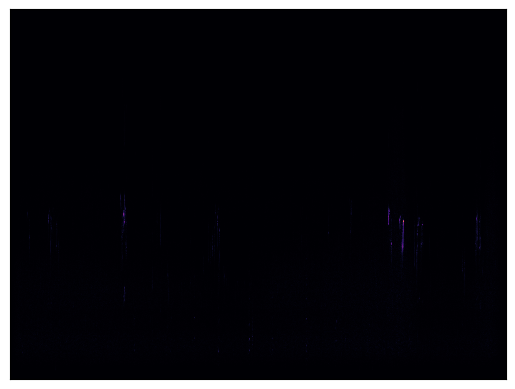

In [8]:
samples, sample_rate = librosa.load(sample_audio_file, sr=None)
sgram = librosa.stft(samples)
librosa.display.specshow(sgram)

In [ ]:
def spectral_gate_and_spectrogram(audio_file, threshold=20, frame_length=2048, hop_length=512, target_size=(128, 128)):
    y, sr = librosa.load(audio_file, sr=None)
    stft = librosa.stft(y, n_fft=frame_length, hop_length=hop_length)
    magnitude, phase = librosa.magphase(stft)
    magnitude_db = librosa.amplitude_to_db(magnitude)

    mask = magnitude_db > threshold
    magnitude_db_filtered = magnitude_db * mask
    filtered_magnitude = librosa.db_to_amplitude(magnitude_db_filtered)
    y_filtered = librosa.istft(filtered_magnitude * phase, hop_length=hop_length)

    S = librosa.feature.melspectrogram(y=y_filtered, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)

    file_name = audio_file[35:-4] + ".mp3"
    if file_name in train_data['filename'].values:
        # Save the spectrogram to a file
        temp = '/content/drive/MyDrive/Train_Spectrogram_Images/' + audio_file[35:-4]
        spectrogram_path = temp + "_spectrogram.png"
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
        plt.axis('off')
        plt.savefig(spectrogram_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        return

    # Open the saved spectrogram and resize
    img = Image.open(spectrogram_path)
    img = img.resize(target_size, Image.ANTIALIAS)

    # Convert to array and normalize
    img_array = img_to_array(img)
    img_array = img_array / 255.0

    return img_array, spectrogram_path


def get_audio_files_and_labels(dataset_dir):
    audio_files = []
    labels = []
    df = pd.read_csv(csv_file)
    for each_audio_file in os.listdir(dataset_dir):
        audio_files.append(os.path.join(dataset_dir, each_audio_file))
        species = df[df['filename'] == each_audio_file[:-4]+".mp3"]
        labels.append(species)

    return audio_files, labels

def preprocess_dataset(audio_files):
    spectrograms = []
    for file in audio_files:
        spectrogram = spectral_gate_and_spectrogram(file)
        spectrograms.append(spectrogram)
    return np.array(spectrograms)

dataset_dir = '/content/drive/MyDrive/BirdDataset'
audio_files, labels = get_audio_files_and_labels(dataset_dir)
spectrograms = preprocess_dataset(audio_files)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(spectrograms, categorical_labels, test_size=0.2, random_state=42)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Assuming your spectrograms are reshaped properly
model = build_model(input_shape=X_train.shape[1:], num_classes=y_train.shape[1])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Save the model
model.save('bird_classification_model.h5')


In [ ]:
from keras.models import load_model

def predict_species(audio_file, model_path='bird_classification_model.h5'):
    model = load_model(model_path)
    spectrogram = spectral_gate_and_spectrogram(audio_file)
    spectrogram = np.expand_dims(spectrogram, axis=0)
    prediction = model.predict(spectrogram)
    predicted_label = np.argmax(prediction, axis=1)
    return encoder.inverse_transform(predicted_label)

# Example usage
# species = predict_species('path_to_new_audio_file.wav')
